# Approximation of Log Determinant

Hongli Zhao, honglizhaobob@uchicago.edu, 04/06/2022

We explore the Hutchinson trick for computing the log determinant of ResNet Jacobian, which is of the form:
$$
    f(z) = z + \text{NN}_{\theta}(z)
$$ where $\text{NN}$ is a neural net parameterized by $\theta$.

* The Jacobian with respect to vector input $z\in\mathbb{R}^d$ is:
$$
    \frac{\partial f}{\partial z} = I_d + \frac{\partial \text{NN}_{\theta}}{\partial z}
$$ where it is assumed that $\text{NN}$ is Lipshcitz with constant $<1$, which is true for normalizing flow since it must define a probability distribution.

* The series approximation is given by (here let $F$ denote the Lipschitz function):
$$
\log|\det (I + DF)| = \text{Tr}(\log(I+DF)) = \sum_{k=1}^{\infty}(-1)^{k+1}\frac{\text{Tr}(DF^k)}{k}
$$ 

We compare how the approximation behaves with respect to truncation order $k$, against exact evaluation.

In [118]:
import numpy as np
import numpy.linalg as la
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd.functional import jacobian
from torch import tensor
torch.manual_seed(0)
np.random.seed(0)

The Lipschitz function $f:\mathbb{R}^d\rightarrow\mathbb{R}^d$ we test is:
$$
    f(z) = 
    \begin{bmatrix}
        \sin z_1\\
        \vdots\\
        \sin z_d
    \end{bmatrix}
$$ then:
$$
    \frac{\partial f}{\partial z_j} = 
    \begin{bmatrix}
        0\\
        \vdots\\
        \cos z_j\\
        \vdots\\
        0
    \end{bmatrix}
$$

In [154]:
# highest dimension for testing
d = 64
# create data point
z = torch.rand([1, d], requires_grad=True)
f_z = torch.sin(z)
Df = jacobian(torch.sin, z).squeeze()
I = torch.eye(d)
target = I+Df
exact = torch.log(torch.det(target))
exact2 = torch.trace(torch.log(target))
assert torch.equal(exact, exact2)

#### Series Approximation

The following code runs for ~10 seconds. `estimate` contains the correct series trunction; `estimate_wrong` is a deliberate mistake, by replacing $\text{Tr}(DF^k)$ with $\text{Tr}(DF)^k$.

In [155]:
truncation_ord = np.arange(1, 200)
mc = len(truncation_ord)
all_errors = np.zeros([1, mc])
estimate = np.zeros([1, mc])
estimate_wrong = np.zeros([1, mc])
for i in range(mc):
    # max truncation order
    n = truncation_ord[i]
    for j in range(n):
        k = j + 1 # k = 1,2,...,n
        estimate[:, i] = estimate[:, i] + ( (((-1)**(k+1))/k) * torch.trace(torch.matrix_power(Df, k)) ).item()
        estimate_wrong[:, i] = estimate_wrong[:, i] + ( (((-1)**(k+1))/k) * ((torch.trace(Df))**k) ).item()

/var/folders/p4/95x8rz8j3q7d9lz7fqtckl240000gn/T/ipykernel_34940/1071192622.py:12: RuntimeWarning: invalid value encountered in add
  estimate_wrong[:, i] = estimate_wrong[:, i] + ( (((-1)**(k+1))/k) * ((torch.trace(Df))**k) ).item()


### Convergence Plot of Results

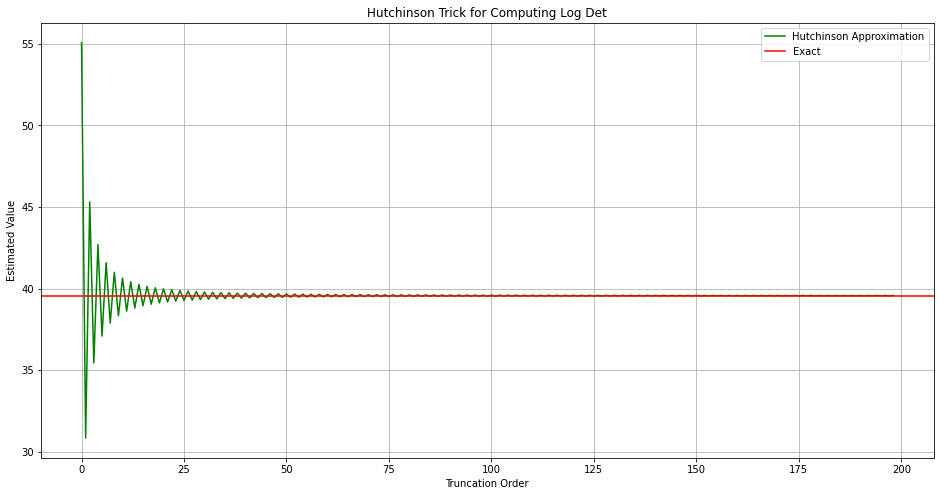

In [156]:
plt.figure(1, figsize=(16, 8))
plt.plot(estimate.T, color='green', lw=1.5, label='Hutchinson Approximation');
plt.axhline(exact, color='red', lw=1.5, label='Exact');
plt.legend(); plt.xlabel("Truncation Order"); plt.ylabel("Estimated Value");
plt.title("Hutchinson Trick for Computing Log Det"); 
plt.grid(True);

### Error Plot

Ploting aboslute error from the exact value.

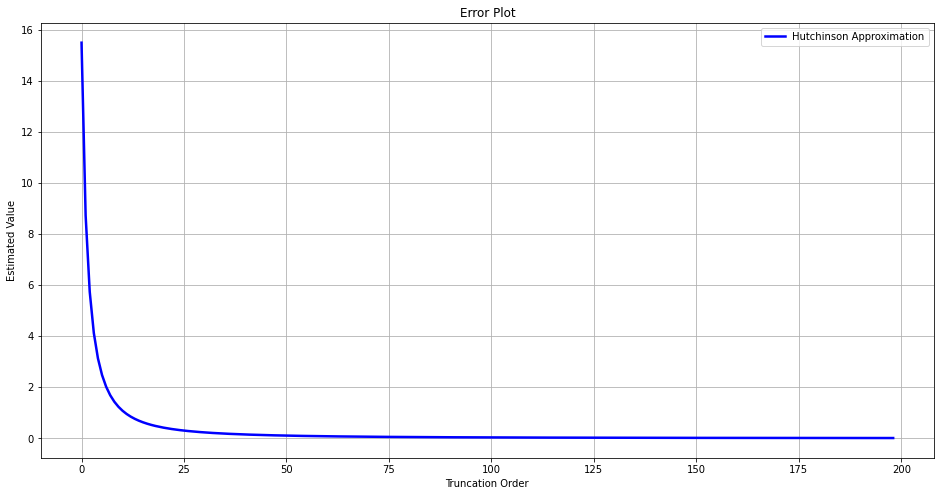

In [157]:
err1 = np.abs(estimate.T - exact.item())
err2 = np.abs(estimate_wrong.T - exact.item())
plt.figure(2, figsize=(16, 8))
plt.plot(err1, color='blue', lw=2.5, label='Hutchinson Approximation');
plt.legend(); plt.xlabel("Truncation Order"); plt.ylabel("Estimated Value");
plt.title("Error Plot"); 
plt.grid(True);

The wrong approximation is indeed deviant.

In [159]:
print(estimate_wrong)

[[ 5.50569077e+01 -1.46057468e+03  5.41700894e+04 -2.24296891e+06
   9.89357271e+07 -4.54321979e+09  2.14527687e+11 -1.03391675e+13
   5.06153098e+14 -2.50866680e+16  1.25587846e+18 -6.33929335e+19
   3.22217355e+21 -1.64750023e+23  8.46674440e+24 -4.37055145e+26
   2.26491165e+28 -1.17779004e+30  6.14361291e+31 -3.21352620e+33
   1.68509614e+35 -8.85628354e+36             inf             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
          